Metadata for x: {'OSR': 8.0, 'fs': 10000.0}
Metadata for y: {'OSR': 8.0, 'fs': 10000.0}
Metadata for y_serial: {'OSR': 8.0, 'fs': 10000.0, 'lut_name': 5.0, 'lut_size': 19.0}
LUT size: 19
LUT name: 5


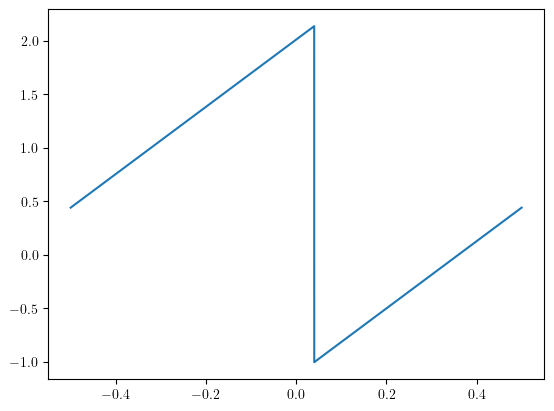

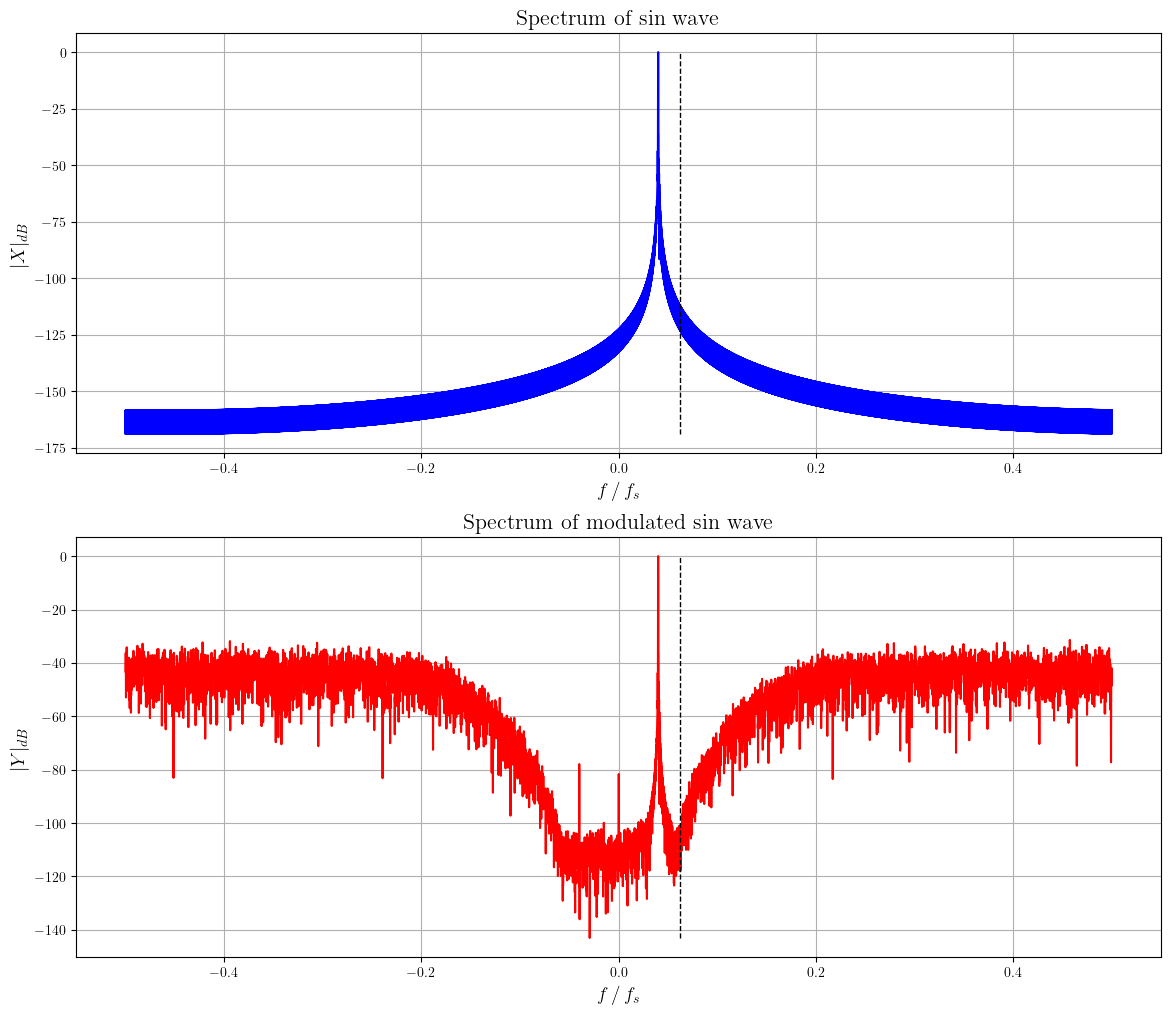

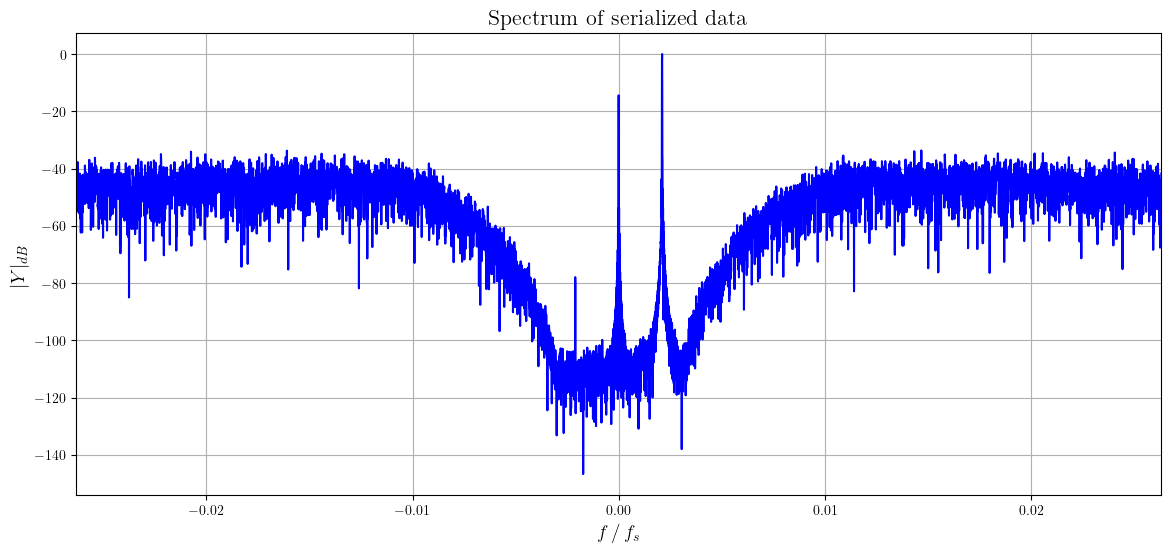

In [37]:
import os
import numpy as np
import scipy.signal as signal
import matplotlib
import matplotlib.pyplot as plt

# Enable LaTeX rendering
plt.rc('text', usetex=True)
plt.rc('font', family='serif')


def read_file_with_header(file_path):
    """
    Reads a file with metadata in the header and numerical data below.
    
    Args:
        file_path (str): Path to the input file.
    
    Returns:
        dict: Metadata key-value pairs.
        np.ndarray: Numerical data as a NumPy array.
    """
    metadata = {}
    data = []

    with open(file_path, 'r') as f:
        for line in f:
            if line.startswith('#'):
                key_value = line[1:].strip().split("=")  # Metadata in format `key=value`
                if len(key_value) == 2:
                    key, value = key_value[0].strip(), key_value[1].strip()
                    try:
                        # Convert numeric metadata to float if possible
                        metadata[key] = float(value) if value.replace('.', '', 1).isdigit() else value
                    except ValueError:
                        metadata[key] = value
            else:
                try:
                    data.append(complex(line.strip()))  # Assuming float values in the data
                except ValueError:
                    pass  # Ignore non-numeric lines

    return metadata, np.array(data)


def assign_metadata_to_variables(metadata):
    """
    Assign metadata values to local variables based on keys.
    
    Args:
        metadata (dict): Metadata key-value pairs.
    
    Returns:
        dict: A dictionary containing local variables for each metadata key.
    """
    local_vars = {}
    for key, value in metadata.items():
        local_vars[key] = value  # Store metadata as local variables in a dictionary
    return local_vars


# Read data and metadata
x_meta, x = read_file_with_header('../data/sinData.txt')
y_meta, y = read_file_with_header('../data/sinData_deltaSigma.txt')
y_serial_meta, y_serial = read_file_with_header('../data/sinData_serialData.txt')

# Assign metadata to local variables
x_vars = assign_metadata_to_variables(x_meta)
y_vars = assign_metadata_to_variables(y_meta)
y_serial_vars = assign_metadata_to_variables(y_serial_meta)

# Example usage of metadata
OSR = int(x_vars.get("OSR", 1))  # Use default OSR=1 if not found in metadata
fs = x_vars.get("fs", None)
# Extract LUT name from metadata
lut_name = int(y_serial_vars.get("lut_name", -1))  # Default to "unknown" if not found
lut_size = int(y_serial_vars.get("lut_size", 0))  # Add LUT size handling

print(f"Metadata for x: {x_vars}")
print(f"Metadata for y: {y_vars}")
print(f"Metadata for y_serial: {y_serial_vars}")
print(f"LUT size: {lut_size}")
print(f"LUT name: {lut_name}")

# Process and plot data
w = signal.barthann(len(x), False)
x_win = x * w
y_win = y * w

N = len(x)

XdB = 20 * np.log10(np.abs(np.fft.fftshift(np.fft.fft(x_win))))
YdB = 20 * np.log10(np.abs(np.fft.fftshift(np.fft.fft(y_win))))

freqs = (np.arange(N) / N - 0.5)

plt.plot(freqs, np.unwrap(np.angle(np.fft.fftshift(np.fft.fft(x)))))
plt.show()

# Plotting
plt.figure(figsize=(14, 12))

# First subplot for XdB
plt.subplot(2, 1, 1)  # 2 rows, 1 column, subplot 1
plt.plot(freqs, XdB - np.max(XdB), label='XdB', color='blue')
plt.plot([0.5 / OSR, 0.5 / OSR], [np.min(XdB - np.max(XdB)), np.max(XdB - np.max(XdB))], '--k', linewidth=1)
plt.title(r'Spectrum of sin wave', fontsize=16)
plt.xlabel(r'$f \, / \, f_s$', fontsize=14)
plt.ylabel(r'$|X|_{dB}$', fontsize=14)
plt.grid()

# Second subplot for YdB
plt.subplot(2, 1, 2)  # 2 rows, 1 column, subplot 2
plt.plot(freqs, YdB - np.max(YdB), label='YdB', color='red')
plt.plot([0.5 / OSR, 0.5 / OSR], [np.min(YdB - np.max(YdB)), np.max(YdB - np.max(YdB))], '--k', linewidth=1)
plt.title(r'Spectrum of modulated sin wave', fontsize=16)
plt.xlabel(r'$f \, / \, f_s$', fontsize=14)
plt.ylabel(r'$|Y|_{dB}$', fontsize=14)
plt.grid()
plt.show()

# deltaSigma_data_fig = f"./figs/sinData_deltaSigma.png"
# plt.savefig(deltaSigma_data_fig)
# print(f"Figure saved as {deltaSigma_data_fig}")

# Process y_serial
w = signal.barthann(len(y_serial), False)
y_serial_win = y_serial * w

N = len(y_serial_win) #// lut_size
epsilon = 1e-12

M = N #// lut_size
freqs = (np.arange(M) / M - 0.5)

y_fft = np.fft.fftshift(np.fft.fft(y_serial_win))
YsdB = 20 * np.log10(np.abs(y_fft))#[int(N/2*(1-1/lut_size)):int(N/2*(1+1/lut_size))]+ epsilon)  # Adding epsilon to avoid log of zero
YsdB -= np.max(YsdB)

# Plotting
plt.figure(figsize=(14, 6))

# Plot YsdB
plt.plot(freqs, YsdB - np.max(YsdB), label='YsdB', color='blue')
plt.title(r'Spectrum of serialized data', fontsize=16)
plt.xlabel(r'$f \, / \, f_s$', fontsize=14)
plt.ylabel(r'$|Y|_{dB}$', fontsize=14)
plt.xlim([-0.5/lut_size,0.5/lut_size])
plt.grid()
plt.show();

# serial_data_fig = f"./figs/sinData_serialData_LUT{lut_name}.png"
# plt.savefig(serial_data_fig)
# print(f"Figure saved as {serial_data_fig}")


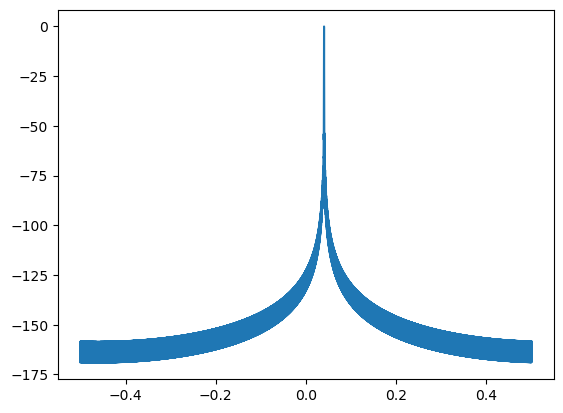

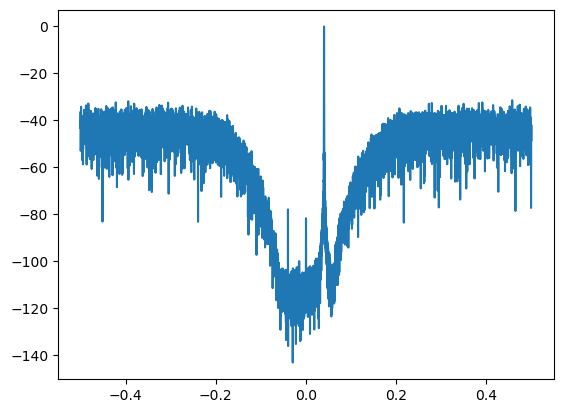

In [17]:
# Read data and metadata
x_meta, x = read_file_with_header('../data/sinData.txt')
y_meta, y = read_file_with_header('../data/sinData_deltaSigma.txt')

x_meta, x = read_file_with_header('../data/sinData.txt')
y_meta, y = read_file_with_header('../data/sinData_deltaSigma.txt')

N = len(x)

w = signal.barthann(len(x), False)
x_win = x * w
y_win = y * w

XdB = 20 * np.log10(np.abs(np.fft.fftshift(np.fft.fft(x_win))))
YdB = 20 * np.log10(np.abs(np.fft.fftshift(np.fft.fft(y_win))))

freqs = (np.arange(N) / N - 0.5)

plt.plot(freqs, XdB - np.max(XdB))
plt.show()

plt.plot(freqs, YdB - np.max(YdB))
plt.show()

ValueError: x and y must have same first dimension, but have shapes (1048576,) and (8192,)

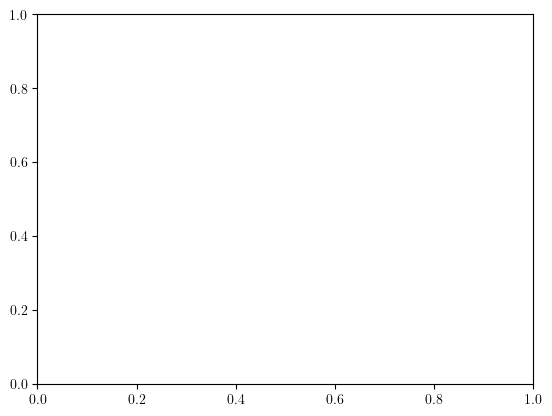

In [32]:
plt.plot(freqs, np.angle(np.fft.fftshift(np.fft.fft(x))))

In [14]:
y_serial_meta, y_serial = read_file_with_header('../data/sinData_serialData_LUT3.txt')
testSignal = y_serial
NyqZones = 4

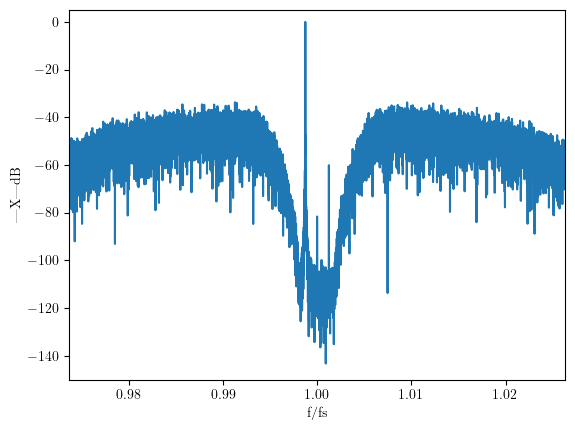

In [26]:
nrz = np.ones(NyqZones-3)

x_upsampled = np.zeros((len(testSignal)-1)*NyqZones+1+3) # Size is (N-1)*M+1, bcs after convolution ((N-1)*M+1) + M - 1 = N*M as it should be!
x_upsampled[::NyqZones] = testSignal.real
x_upsampled[1::NyqZones] = testSignal.imag
x_upsampled[2::NyqZones] = -testSignal.real
x_upsampled[3::NyqZones] = -testSignal.imag

x_nrz = np.convolve(nrz, x_upsampled)

w = signal.barthann(len(x_nrz), False)
x_nrz_win = x_nrz * w

XnrzdB = 20*np.log10(np.fft.fftshift(abs(np.fft.fft(x_nrz_win))))
XnrzdB -= np.max(XnrzdB)

freqs = (np.arange(len(x_nrz_win)) / len(x_nrz_win) - 0.5) * NyqZones #* len(y_serial) / len(x)

plt.plot(freqs, XnrzdB)
# plt.ylim([-200, 0])
plt.xlim([1-0.5/(len(y_serial) / len(x)), 1+0.5/(len(y_serial) / len(x))])
plt.xlabel("f/fs")
plt.ylabel("|X|dB")
plt.ylim([-150, 5])
plt.show()